In [1]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
## dont really need cause cant vectorize on this machine ( But still adding)
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GridSimulator
HeatSimulation = GridSimulator.ClassHeatSimulation()

# Agent #1

### Initializing my simulator

In [2]:
NumberOfNodes = 10
Length = .1
Density = 7800
HeatCapacity = 500
ThermalConductivity = 16.2 

Set Properties

In [3]:
HeatSimulation.SetSize(.003,.003)
HeatSimulation.SetConvectionProperties(4,25)
HeatSimulation.EnableSurfaceHeatTransfer(False)
HeatSimulation.SetHeatSource(25)
HeatSimulation.SetInitalTemp(25)
HeatSimulation.SetNodes(NumberOfNodes, Length)
HeatSimulation.SetMaterialProperties(Density,HeatCapacity,ThermalConductivity)

Find suggested time constant

In [4]:
HeatSimulation.UpdatePropertiesTable()
print("Largest Suggested Time Constant: " + str(HeatSimulation.SuggestedTimeInc(True))+ "s")
HeatSimulation.PropsTable

Largest Suggested Time Constant: 7s


,Node,R_Left,R_Right,R_Top,ThermCap,C/(1/R)
0,1.0,68.587106,68.587106,0.0,0.3510,12.037037
1,2.0,68.587106,68.587106,0.0,0.3510,12.037037
2,3.0,68.587106,68.587106,0.0,0.3510,12.037037
3,4.0,68.587106,68.587106,0.0,0.3510,12.037037
4,5.0,68.587106,68.587106,0.0,0.3510,12.037037
5,6.0,68.587106,68.587106,0.0,0.3510,12.037037
6,7.0,68.587106,68.587106,0.0,0.3510,12.037037
7,8.0,68.587106,68.587106,0.0,0.3510,12.037037
8,9.0,68.587106,68.587106,0.0,0.3510,12.037037
9,10.0,68.587106,0.000000,0.0,0.1755,12.037037


Set Time Constant

In [5]:
HeatSimulation.SetTimeIncrement(1)

In [6]:
class Agent1(Env):
    
    def __init__(self):
        #triggers when class created
        # Actions we can take Increase/decrease no change on temp
        self.action_space = Discrete(125)
        self.observation_space = Box(low=0, high=250, shape=(1,))
        # Set start temp
        self.state = np.array([22 + random.randint(-3,3)]).astype(float)
        self.TempatureProfile = HeatSimulation.Temps
        # Set episode length
        self.Time = 0
        self.TimeLength = 7200
        # 2 hours
        self.TimeInc = 10

        
    def step(self, action):
        # here is where the simulator interfaces
        self.Time += self.TimeInc
        #num = random.randint(0,100)
        #HeatSimulation.SetHeatSource((num+125))
        #print(num)
        HeatSimulation.SetHeatSource(action+100)
        #print(self.TempatureProfile)
        #print(0)
        HeatSimulation.SetInitalTempProfile(self.TempatureProfile)
        #print(self.Time)
        #print(HeatSimulation.GlobalTime)
        Temperature = HeatSimulation.GetTempatureAtNodeAtTime(self.Time-self.TimeInc,self.Time,10)
        #print(Temperature)
        self.TempatureProfile = HeatSimulation.Temps
        #print(self.TempatureProfile)
        #print(Temperature)
        # self.state = Temperature
        self.state = np.array([Temperature]).astype(float)
      
        # Calculate reward
        if (self.state >=130) and (self.state <=135): 
            reward =1 
        else: 
            reward = -1 
        
        # Check if shower is done
        if self.Time >= self.TimeLength: 
            done = True
        else:
            done = False
        
        
        # Apply temperature noise
        #self.state += random.randint(-1,1)
        # Set placeholder for info that can be outputted
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
#         Complicated i think
        pass
    
    def reset(self):
        # Reset shower temperature
        self.state = np.array([22 + random.randint(-3,3)]).astype(float)
        # Reset shower time
        self.Time = 0
        RandomTemp = 22 + random.randint(-3,3)
        HeatSimulation.SetSize(.003,.003)
        HeatSimulation.SetConvectionProperties(4,RandomTemp)
        HeatSimulation.EnableSurfaceHeatTransfer(False)
        HeatSimulation.SetHeatSource(RandomTemp)
        HeatSimulation.SetInitalTemp(RandomTemp)
        HeatSimulation.SetNodes(NumberOfNodes, Length)
        HeatSimulation.SetMaterialProperties(Density,HeatCapacity,ThermalConductivity)
        return self.state

#### Defining this class as a enviroment

In [7]:
env=Agent1()

## Testing the enviroment, dont need to run

Episode:1 Score:-686


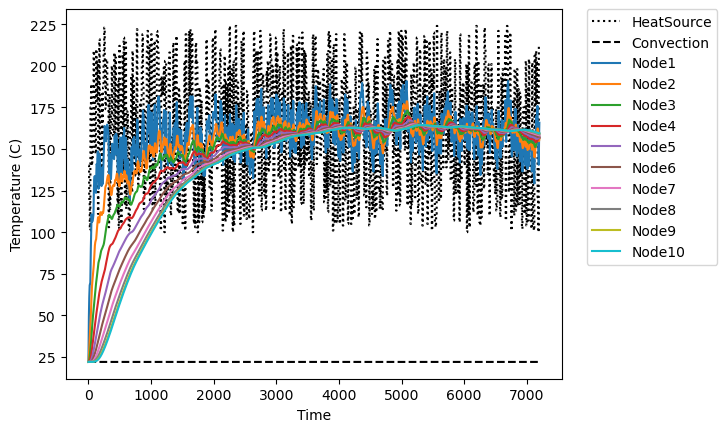

In [8]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    #print(score)
    print('Episode:{} Score:{}'.format(episode, score))
    HeatSimulation.GraphResults("")
env.close()

# Training

In [11]:
log_path = os.path.join('Training', 'Logs')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Set training time steps, Larger than one episode
### One episode is set at 7200s

In [12]:
TrainningSteps = 72000

## Begin Trainning

In [13]:
model.learn(total_timesteps=TrainningSteps)

Logging to Training/Logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | -686     |
| time/              |          |
|    fps             | 11       |
|    iterations      | 1        |
|    time_elapsed    | 171      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_rew_mean          | -687        |
| time/                   |             |
|    fps                  | 12          |
|    iterations           | 2           |
|    time_elapsed         | 320         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018188786 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.82       |
|    explained_variance   | 0.00352     |

## attempting to evaluate

Score: -720


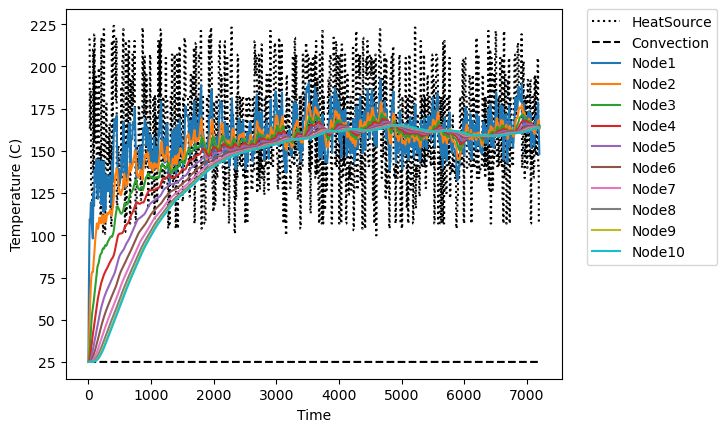

In [15]:
state = env.reset()
obs = env.reset()

done = False
score = 0 
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    score+=reward
print('Score: ' + str(score))
HeatSimulation.GraphResults("")
env.close()

Score: -720


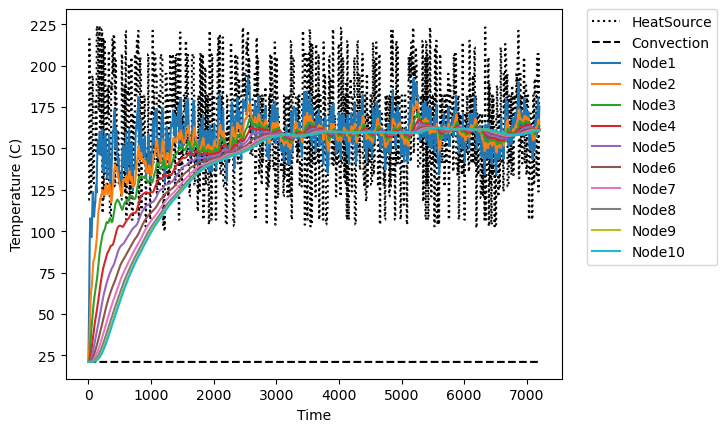

In [16]:
state = env.reset()
obs = env.reset()

done = False
score = 0 
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    score+=reward
print('Score: ' + str(score))
HeatSimulation.GraphResults("")
env.close()

In [23]:
isInTheZone = (HeatSimulation.AllTemp.Node10 > 130) & (HeatSimulation.AllTemp.Node10 < 135)
print("Length: " + str(len(isInTheZone)))
print("Score: " + str(np.sum(isInTheZone)))


Length: 7201
Score: 131


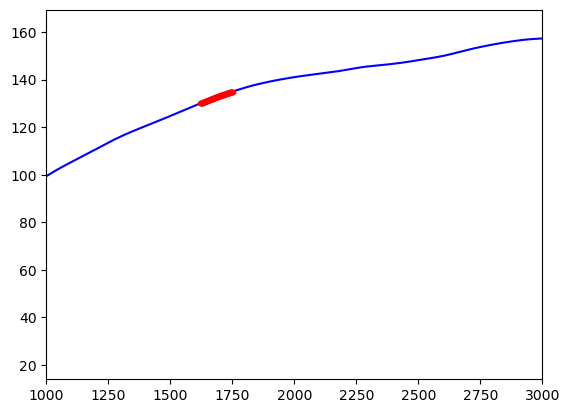

In [26]:
plt.figure()
plt.plot(HeatSimulation.AllTemp.Time, HeatSimulation.AllTemp.Node10, '-b')
plt.plot(HeatSimulation.AllTemp.Time[isInTheZone], HeatSimulation.AllTemp.Node10[isInTheZone], '.r')
plt.xlim(1000, 3000)
plt.show()

In [27]:
scoreGuess = ((7201 - 131)*(-1) + 131)/10
print(scoreGuess)

-693.9


# Saving Model

In [20]:
PPO_path = os.path.join('Training', 'SavedModels')
model.save(PPO_path)

In [21]:
print(PPO_path)

Training/SavedModels


### might eval it

In [ ]:
evaluate_policy(model, env, n_eval_episodes=10, render=False)